## Assignment - BugendaiTech
#### Data Extraction from Text file and Binary Classification.
#### Here the Notebook is divided into 4 Sections
#### 1. Data Conversion (.txt to DataFrame)
#### 2. Data Preprocessing
#### 2. Exploratory Data Analysis
#### 3. Modelling

### Data Conversion

In [1]:
import io
import os
import re
import pandas as pd
import numpy as np
import fasttext as fastText
import transformers as ppb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import nltk
from sklearn.decomposition import PCA, TruncatedSVD
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import LSTM, Activation, Dropout, Dense, Input
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = nltk.corpus.stopwords.words('english')


class Text_to_df:
    """Convert text data to Dataframe

    Args:
        file_name: Name of the text file
    Returns:
        Dataframe with columns - content,if_reply (yes/no), reply_count,
        if_forward (yes/no), forward_count, header_subject
    """
    def __init__(self, file_name):
        self.file_name = file_name
        self.counter = 0
        
    def open_split(self):
        f = open(self.file_name, "r")
        text = f.read()
        return text.split("THREAD_END")

    def convert(self):
        data = []
        threads = self.open_split()
        for thread in threads:
            sub_data = {}
            thread=thread.replace('\n',' ')
            self.counter += 1
            sub_data['Thread_No.'] = self.counter
            result = re.search('HEADER_SUBJECT(.*)EMAIL_START ', thread)
            if result is not None: 
                sub_data['header_subject'] = result.group(1).strip()
                
            result = re.search('HEADER_CONTENT(.*)EMAIL_END ', thread)
            if result is not None: 
                sub_data['content'] = result.group(1).strip()
                
            result = re.findall(r'FORWARD_START', thread)
            if len(result) > 0:
                sub_data['if_forward'] = 'yes'
                sub_data['forward_count'] = len(result)
            else:
                sub_data['if_forward'] = 'no'
                sub_data['forward_count'] = 0
            
            result = re.findall(r'REPLY_START', thread)
            if len(result) > 0:
                sub_data['if_reply'] = 'yes'
                sub_data['reply_count'] = len(result)
            else:
                sub_data['if_reply'] = 'no'
                sub_data['reply_count'] = 0
                
            data.append(sub_data) 
        df = pd.DataFrame(data)
        return df

C:\Users\91903\anaconda3\envs\kali\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\91903\anaconda3\envs\kali\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\91903\anaconda3\envs\kali\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
c = Text_to_df("../../INterview/assignment_2/assignment_2/data.txt")
df = c.convert()

In [3]:
df

,Thread_No.,header_subject,content,if_forward,forward_count,if_reply,reply_count
0,1,SMUD,cc: Sara - SMUD gave us their version of the ...,no,0,no,0
1,2,Authorized Signers,"cc: Gary Hickerson/HOU/ECT@ECT, John Greene/LO...",yes,1,yes,1
2,3,ISDA Master Agreements,"cc: Sara It has been agreed between ENA, ECT...",no,0,yes,1
3,4,"From MEGA, Consent to Assignment....","cc: ""Abba Gana, Mustapha"" <AbbaGanaM@merchante...",no,0,yes,1
4,5,Enron PATS 2000-1,"In connection with Enron's PATS offering, we'r...",yes,2,no,0
...,...,...,...,...,...,...,...
2996,2997,Re: Meeting,To: Chris Germany/HOU/ECT@ECT cc: Subject: Re:...,no,0,yes,1
2997,2998,Capacity Releases,"cc: Scott Neal/HOU/ECT@ECT, Dick Jenkins/HOU/E...",no,0,no,0
2998,2999,Re: Devonian Resources,cc: I believe that this is metered production...,no,0,yes,1
2999,3000,Re: Advantages of being a man...,I love being a MAN!!! Ain't life great?,no,0,yes,1


## Data Preprocessing 

In [4]:
def data_cleaning(text):
    text = ' '.join([item for item in str(text).split() if '@' not in item])
    text = re.sub('cc:', '', text)
    text = re.sub(r'[^A-Za-z]+', ' ', text)
    text = text.lower()
    return text

In [5]:
df['clean_content'] = df['content'].apply(lambda x: data_cleaning(x))

In [6]:
lemmatizer = WordNetLemmatizer()
df["clean_content"] =  df["clean_content"].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(sentence)]))

In [7]:
def remove_stopwords(text):
    text = ' '.join([w for w in word_tokenize(text)  if not w in stopwords and len(w)>1]) 
    return text

In [8]:
df['clean_stop_content'] = df['clean_content'].apply(lambda x: remove_stopwords(x))

In [9]:
df.head()

,Thread_No.,header_subject,content,if_forward,forward_count,if_reply,reply_count,clean_content,clean_stop_content
0,1,SMUD,cc: Sara - SMUD gave us their version of the ...,no,0,no,0,sara smud gave u their version of the isda agr...,sara smud gave version isda agreement week ago...
1,2,Authorized Signers,"cc: Gary Hickerson/HOU/ECT@ECT, John Greene/LO...",yes,1,yes,1,gary john michael w aneela theresa t patrick a...,gary john michael aneela theresa patrick miche...
2,3,ISDA Master Agreements,"cc: Sara It has been agreed between ENA, ECT...",no,0,yes,1,sara it ha been agreed between ena ectric and ...,sara ha agreed ena ectric referred way novatio...
3,4,"From MEGA, Consent to Assignment....","cc: ""Abba Gana, Mustapha"" <AbbaGanaM@merchante...",no,0,yes,1,abba gana mustapha susan please find attached ...,abba gana mustapha susan please find attached ...
4,5,Enron PATS 2000-1,"In connection with Enron's PATS offering, we'r...",yes,2,no,0,in connection with enron s pat offering we re ...,connection enron pat offering attaching cover ...


In [10]:
labelencoder = LabelEncoder()
df['if_reply'] = labelencoder.fit_transform(df['if_reply'])
df['if_forward'] = labelencoder.fit_transform(df['if_forward'])
df.head(10)

,Thread_No.,header_subject,content,if_forward,forward_count,if_reply,reply_count,clean_content,clean_stop_content
0,1,SMUD,cc: Sara - SMUD gave us their version of the ...,0,0,0,0,sara smud gave u their version of the isda agr...,sara smud gave version isda agreement week ago...
1,2,Authorized Signers,"cc: Gary Hickerson/HOU/ECT@ECT, John Greene/LO...",1,1,1,1,gary john michael w aneela theresa t patrick a...,gary john michael aneela theresa patrick miche...
2,3,ISDA Master Agreements,"cc: Sara It has been agreed between ENA, ECT...",0,0,1,1,sara it ha been agreed between ena ectric and ...,sara ha agreed ena ectric referred way novatio...
3,4,"From MEGA, Consent to Assignment....","cc: ""Abba Gana, Mustapha"" <AbbaGanaM@merchante...",0,0,1,1,abba gana mustapha susan please find attached ...,abba gana mustapha susan please find attached ...
4,5,Enron PATS 2000-1,"In connection with Enron's PATS offering, we'r...",1,2,0,0,in connection with enron s pat offering we re ...,connection enron pat offering attaching cover ...
5,6,ISDA/Financial Trades for Washington State PUD...,cc: Sara - Jeff Fuller is interested in purs...,1,1,0,0,sara jeff fuller is interested in pursuing isd...,sara jeff fuller interested pursuing isda numb...
6,7,Trip to Argentina,"Sara: I confirm a meeting with Andres Hall, d...",0,0,0,0,sara i confirm a meeting with andres hall dire...,sara confirm meeting andres hall director secu...
7,8,Engage Energy US/Coastal Merchant Energy Name ...,"? ? For your information, please see six (6) a...",1,3,0,0,for your information please see six attachment...,information please see six attachment regardin...
8,9,Re: Alcoa Master Agreement,cc: Sara Shackleton/HOU/ECT@ECT Noel: I am o...,0,0,1,2,sara noel i am on maternity leave please conta...,sara noel maternity leave please contact sara ...
9,10,EnronCredit.com Limited electronic trading agr...,Justin/Paul: The Houston contingent of EnronCr...,0,0,1,1,justin paul the houston contingent of enroncre...,justin paul houston contingent enroncredit com...


## Exploratory Data Analysis

#### First of all lets check the class distribution

C:\Users\91903\anaconda3\envs\kali\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


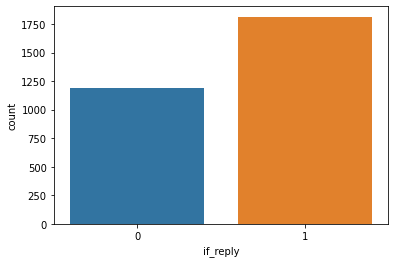

In [11]:
import seaborn as sns
ax = sns.countplot(df['if_reply'])

In [12]:
def renderWordcloud(text):
    wordcloud = WordCloud().generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    F = plt.gcf()
    Size = F.get_size_inches()
    F.set_size_inches(Size[0]*2, Size[1]*2, forward=True) # Set forward to True to resize window along with plot in figure.
    plt.show()

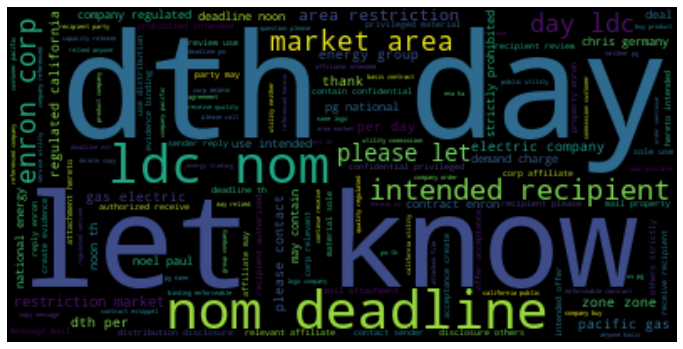

In [13]:
text = " ".join(keyword for keyword in df.clean_stop_content)
renderWordcloud(text)

In [14]:
def create_corpus(target):
    corpus=[]
    for x in df[df['if_reply']==target]['clean_stop_content'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

#### Creating Word Corpus to check most frequent words

#### Most Frequent Words in Replied Mails

In [15]:
corpus1=create_corpus(1)
dic=defaultdict(int)
for word in corpus1:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]
print(top)

[('gas', 1713), ('please', 1222), ('contract', 1075), ('enron', 1070), ('company', 1051), ('deal', 916), ('ena', 913), ('know', 809), ('dth', 780), ('intended', 776), ('day', 750), ('recipient', 734), ('chris', 734), ('may', 732), ('energy', 691), ('need', 691), ('let', 618), ('corp', 610), ('ha', 590), ('sonat', 576)]


<BarContainer object of 20 artists>

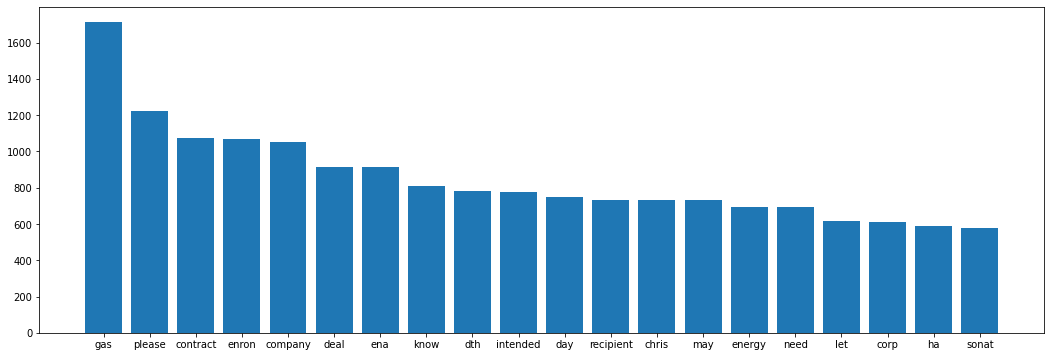

In [16]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

#### Most Frequent Words in Not Replied Mails

In [17]:
corpus0=create_corpus(0)
dic=defaultdict(int)
for word in corpus0:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:20]
print(top)

[('day', 1374), ('dth', 1328), ('gas', 866), ('please', 815), ('th', 770), ('nom', 763), ('deadline', 730), ('ldc', 722), ('market', 702), ('area', 679), ('need', 541), ('enron', 515), ('restriction', 501), ('know', 426), ('capacity', 404), ('deal', 385), ('let', 345), ('available', 343), ('per', 343), ('contract', 327)]


<BarContainer object of 20 artists>

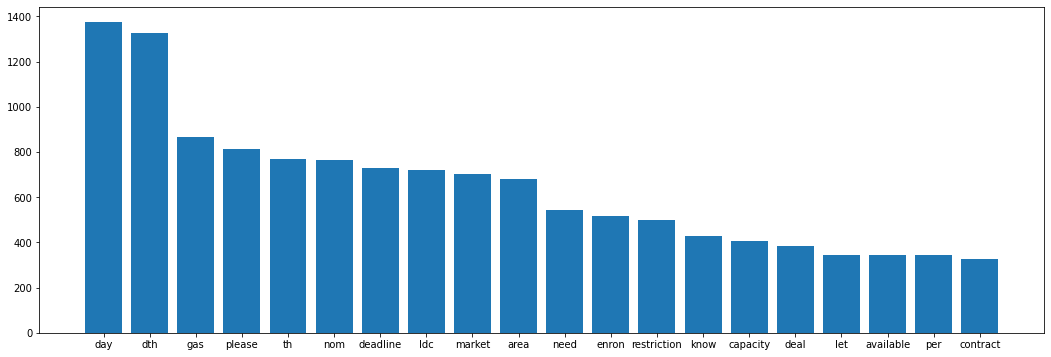

In [18]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

### Using N-Gram = 2

#### Most Frequent Consecutive Words Occuring together 

In [19]:
def get_top_content_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

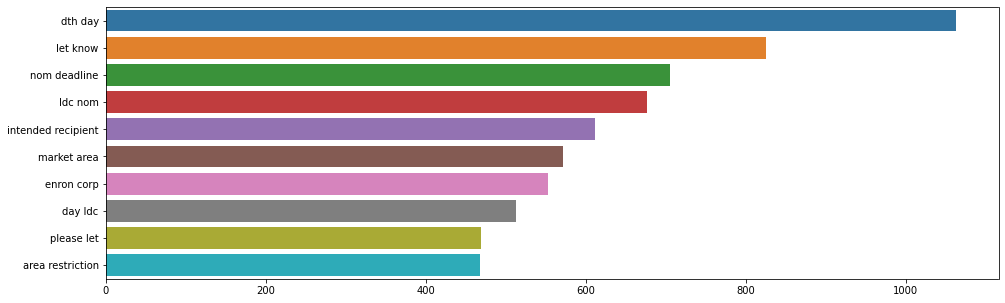

In [20]:
plt.figure(figsize=(16,5))
top_content_bigrams=get_top_content_bigrams(df['clean_stop_content'])[:10]
x,y=map(list,zip(*top_content_bigrams))
sns.barplot(x=y,y=x)

### Average no. of Words in a Mail

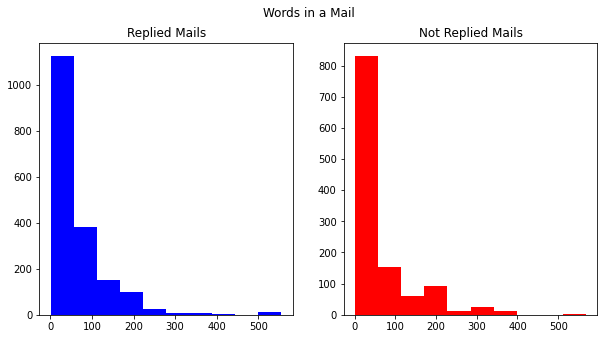

In [21]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
Mail_len=df[df['if_reply']==1]['clean_stop_content'].str.split().map(lambda x: len(x))
ax1.hist(Mail_len,color='blue')
ax1.set_title('Replied Mails')
Mail_len=df[df['if_reply']==0]['clean_stop_content'].str.split().map(lambda x: len(x))
ax2.hist(Mail_len,color='red')
ax2.set_title('Not Replied Mails')
fig.suptitle('Words in a Mail')
plt.show()

## Models

In [22]:
content = df["clean_stop_content"].tolist()
reply = df["if_reply"].tolist()

X_train, X_test, y_train, y_test = train_test_split(content, reply, test_size=0.2, random_state=0)

### Vectorization for Modelling

#### 1. Count Vectorizer - Visualizing the Embeddings

In [23]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(X_train)

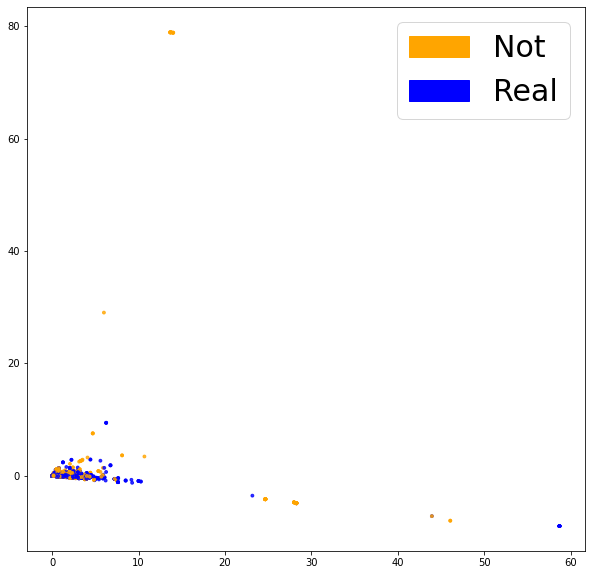

In [24]:
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='Not')
            blue_patch = mpatches.Patch(color='blue', label='Real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})

fig = plt.figure(figsize=(10, 10))          
plot_LSA(train_vectors, y_train)
plt.show()

#### 2. TFIDF Vectorizer - Visualizing the Embeddings

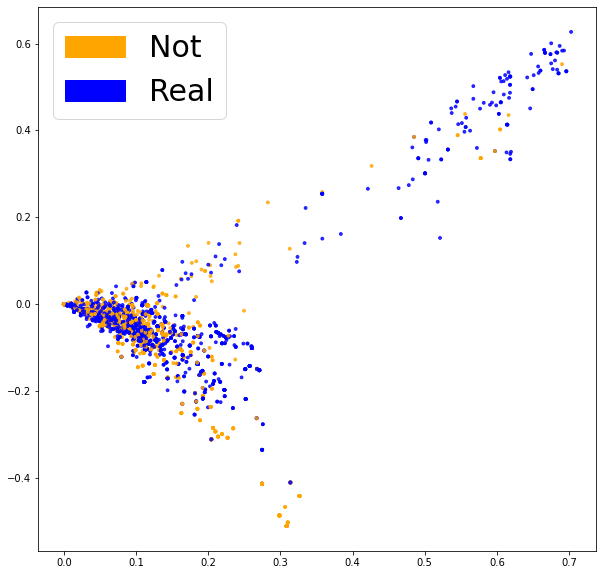

In [25]:
tfidf_vectorizer = TfidfVectorizer()
train_vectors = tfidf_vectorizer.fit_transform(X_train)
fig = plt.figure(figsize=(10, 10))          
plot_LSA(train_vectors, y_train)
plt.show()

### Linear Ridge Classifier with Count Vectorizer

In [26]:
train_vectors = count_vectorizer.fit_transform(X_train)
test_vectors = count_vectorizer.transform(X_test)
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, y_train)
predictions = clf.predict(test_vectors)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78       235
           1       0.87      0.84      0.86       366

    accuracy                           0.83       601
   macro avg       0.82      0.82      0.82       601
weighted avg       0.83      0.83      0.83       601



### Linear Ridge Classifier with TFIDF Vectorizer

In [27]:
train_vectors = tfidf_vectorizer.fit_transform(X_train)
test_vectors = tfidf_vectorizer.transform(X_test)
clf = linear_model.RidgeClassifier()
clf.fit(train_vectors, y_train)
predictions = clf.predict(test_vectors)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       235
           1       0.86      0.88      0.87       366

    accuracy                           0.84       601
   macro avg       0.84      0.83      0.83       601
weighted avg       0.84      0.84      0.84       601



### Multiple Classifiers 

In [28]:
from sklearn.base import BaseEstimator
class ClfSwitcher(BaseEstimator):
    def __init__(self, estimator = linear_model.RidgeClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

In [29]:
clf = linear_model.RidgeClassifier()
pipeline = Pipeline([('tfidf', TfidfVectorizer()), ('clf', ClfSwitcher())])

parameters = [
    {
        'clf__estimator': [SVC()],
    },
    {
        'clf__estimator': [SGDClassifier()],
    },
    {
        'clf__estimator': [MultinomialNB()],
    },
    {
        'clf__estimator': [linear_model.RidgeClassifier()],
    },
    {
        'clf__estimator': [MLPClassifier(random_state=1, max_iter=200, early_stopping=True)],
    }
]

os.write(1, b"Starting grid search of models\n")
gscv = GridSearchCV(pipeline, parameters, cv=4, n_jobs=12, return_train_score=True, verbose=3, scoring='f1')


In [30]:
gscv.fit(df["clean_stop_content"],df["if_reply"])

Fitting 4 folds for each of 5 candidates, totalling 20 fits


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [SVC()]},
                         {'clf__estimator': [SGDClassifier()]},
                         {'clf__estimator': [MultinomialNB()]},
                         {'clf__estimator': [RidgeClassifier()]},
                         {'clf__estimator': [MLPClassifier(early_stopping=True,
                                                           random_state=1)]}],
             return_train_score=True, scoring='f1', verbose=3)

In [31]:
df2 = pd.DataFrame(gscv.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__estimator,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,1.317296,0.078863,0.406091,0.026792,SVC(),{'clf__estimator': SVC()},0.858757,0.881152,0.891892,0.879684,0.877871,0.012000,1,0.944290,0.950226,0.945216,0.945976,0.946427,0.002273
1,0.229302,0.005805,0.043010,0.003938,SGDClassifier(),{'clf__estimator': SGDClassifier()},0.861905,0.875306,0.868421,0.878942,0.871143,0.006537,3,0.946924,0.952081,0.945046,0.949302,0.948338,0.002635
2,0.215298,0.003420,0.043009,0.005245,MultinomialNB(),{'clf__estimator': MultinomialNB()},0.816543,0.828729,0.879859,0.854167,0.844824,0.024360,5,0.884327,0.875809,0.881013,0.886059,0.881802,0.003906
3,0.154784,0.005495,0.048011,0.007002,RidgeClassifier(),{'clf__estimator': RidgeClassifier()},0.863795,0.878049,0.877095,0.866600,0.871385,0.006275,2,0.940236,0.945645,0.938319,0.942040,0.941560,0.002700
4,20.414333,2.652146,0.034257,0.003898,"MLPClassifier(early_stopping=True, random_stat...",{'clf__estimator': MLPClassifier(early_stoppin...,0.845977,0.853333,0.864662,0.864173,0.857036,0.007828,4,0.919959,0.923767,0.939265,0.923188,0.926545,0.007486


SVC seems to performs better than others

### SVC Model

In [32]:
model = SVC() 
model.fit(train_vectors, y_train) 
   
# print prediction results 
predictions = model.predict(test_vectors) 
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       235
           1       0.85      0.89      0.87       366

    accuracy                           0.84       601
   macro avg       0.84      0.83      0.83       601
weighted avg       0.84      0.84      0.84       601



In [33]:
param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['rbf','linear','sigmoid']}  
   
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,n_jobs=12) 
   
# fitting the model for grid search 
grid.fit(train_vectors, y_train) 
 
# print best parameter after tuning 
print(grid.best_params_) 
grid_predictions = grid.predict(test_vectors) 
   
print(classification_report(y_test, grid_predictions)) 

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       235
           1       0.86      0.89      0.87       366

    accuracy                           0.84       601
   macro avg       0.84      0.83      0.83       601
weighted avg       0.84      0.84      0.84       601



### Using LSTM with Glove Embedding

In [34]:
content = df["clean_stop_content"].tolist()
reply = df["if_reply"].tolist()
X_train, X_test, y_train, y_test = train_test_split(content, reply, test_size=0.2, random_state=0)

In [35]:
tokenizer = Tokenizer(num_words=6000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [36]:
def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

Finding Maximum no. of words present in a mail

In [37]:
maxi = 0
for i in content:
    content2 = i.split(" ")
    M = len(content2)
    if M>maxi:
        maxi = M
        N = i
        content3 = content2

In [38]:
print("Maximum No. of words",maxi)
print(N)

Maximum No. of words 568
october value go enron floyd norris ole obj hat really went opaque transaction insider ever seen wall street ha puzzling since enron news quote redirect marketwatch redirect ctx mw http custom marketwatch com custom nyt com html companyprofile asp symb ene released quarterly earnings week ago yesterday share enron plunged company said security exchange commission wa looking transaction reaction wa way puzzling given question raised since earnings announcement prominently featured wall street journal wa likely would begin preliminary inquiry whether go farther clear nothing else slide enron share last week show hazard confront company allows word major reduction balance sheet value dribble enron share rose cent last tuesday investor first reacted earnings announcement since fallen percent billion reduction shareholder equity wa mentioned news release enron issued quarterly earnings last tuesday wa briefly mentioned conference call analyst many listener seem noti

Importing Glove Embedding

In [39]:
word_to_vec_map = read_glove_vector('../Glove_Embedding/glove.6B.100d.txt')
maxLen = 568

In [40]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]
emb_matrix = np.zeros((vocab_len, embed_vector_len))
for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    try:
        if embedding_vector is not None:
            emb_matrix[index, :] = embedding_vector
    except: 
        pass

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [44]:
def Mail_Reply(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = LSTM(128, return_sequences=True)(embeddings)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

In [64]:
model = Mail_Reply((maxLen,))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 568)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 568, 100)          702400    
_________________________________________________________________
lstm_7 (LSTM)                (None, 568, 128)          117248    
_________________________________________________________________
dropout_7 (Dropout)          (None, 568, 128)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 568, 128)          131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 568, 128)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               1315

In [65]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(2400, 568)

In [67]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
Y_train = np.array(y_train)
model.fit(X_train_indices, Y_train, batch_size=64, epochs=3)

Epoch 1/3
38/38 [==============================] - 148s 4s/step - loss: 0.6706 - accuracy: 0.6035
Epoch 2/3
38/38 [==============================] - 148s 4s/step - loss: 0.6710 - accuracy: 0.5992
Epoch 3/3
38/38 [==============================] - 148s 4s/step - loss: 0.6807 - accuracy: 0.5779


LSTM didn't fit well on this data. Tried it on 15 and 20 epochs as well.

#### Conv1D + Glove Embedding

In [85]:
def conv1d_model(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Conv1D(512,3,activation='relu')(embeddings)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256,3,activation='relu')(X)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256,3,activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(3)(X)
    X = GlobalMaxPooling1D()(X)
    X = Dense(256, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

In [105]:
model = conv1d_model((maxLen,))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 568)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 568, 100)          702400    
_________________________________________________________________
conv1d (Conv1D)              (None, 566, 512)          154112    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 188, 512)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 186, 256)          393472    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60, 256)           196864

In [60]:
X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(2400, 568)

In [61]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
Y_train = np.array(y_train)
model.fit(X_train_indices, Y_train, batch_size=64, epochs=15)

Epoch 1/15
38/38 [==============================] - 13s 316ms/step - loss: 0.3502 - accuracy: 0.8535
Epoch 2/15
38/38 [==============================] - 12s 316ms/step - loss: 0.2793 - accuracy: 0.8836
Epoch 3/15
38/38 [==============================] - 12s 315ms/step - loss: 0.2831 - accuracy: 0.8837
Epoch 4/15
38/38 [==============================] - 12s 318ms/step - loss: 0.2716 - accuracy: 0.8862
Epoch 5/15
38/38 [==============================] - 12s 316ms/step - loss: 0.3307 - accuracy: 0.8703
Epoch 6/15
38/38 [==============================] - 12s 315ms/step - loss: 0.2671 - accuracy: 0.9041
Epoch 7/15
38/38 [==============================] - 12s 315ms/step - loss: 0.2385 - accuracy: 0.9059
Epoch 8/15
38/38 [==============================] - 12s 316ms/step - loss: 0.2377 - accuracy: 0.9088
Epoch 9/15
38/38 [==============================] - 12s 316ms/step - loss: 0.2184 - accuracy: 0.9176
Epoch 10/15
38/38 [==============================] - 12s 317ms/step - loss: 0.2215 - accura

In [63]:
Y_test = np.array(y_test)
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
model.evaluate(X_test_indices, Y_test)

19/19 [==============================] - 1s 43ms/step - loss: 0.3761 - accuracy: 0.8286


[0.3760544955730438, 0.8286189436912537]

Conv1D performed well than LSTM, lets check the combination of both.

### Conv1D + LSTM + Glove Embedding

In [108]:
def conv_lstm(input_shape):
    X_indices = Input(input_shape)
    embeddings = embedding_layer(X_indices)
    X = Conv1D(512,3,activation='relu')(embeddings)
    X = MaxPooling1D(3)(X)
    X = Conv1D(256,3,activation='relu')(X)
    X = MaxPooling1D(3)(X)
    X = Dropout(0.8)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs=X_indices, outputs=X)
    return model

In [109]:
model = conv_lstm((maxLen,))
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 568)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 568, 100)          702400    
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 566, 512)          154112    
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 188, 512)          0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 186, 256)          393472    
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 62, 256)           0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 62, 256)           0  

In [113]:
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen, padding='post')
X_train_indices.shape

(2400, 568)

In [ ]:
adam = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
Y_train = np.array(y_train)
model.fit(X_train_indices, Y_train, batch_size=64, epochs=20)

Epoch 1/20
38/38 [==============================] - 16s 388ms/step - loss: 0.3502 - accuracy: 0.8649
Epoch 2/20
14/38 [==========>...................] - ETA: 9s - loss: 0.3101 - accuracy: 0.8830

In [86]:
Y_test = np.array(y_test)
X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')
model.evaluate(X_test_indices, Y_test)

19/19 [==============================] - 3s 126ms/step - loss: 0.4711 - accuracy: 0.7922


[0.47114768624305725, 0.7921903729438782]

## FastText Classifier 

Creating Training & Testing File as per FastText Requirement

In [42]:
content = df["clean_stop_content"].tolist()
reply = df["if_reply"].tolist()

X_train, X_test, y_train, y_test = train_test_split(content, reply, test_size=0.2, random_state=0)
with io.open('../../INterview/assignment_2/assignment_2/training_mail.txt', 'w', encoding = "utf-8") as f:
    for each_text, each_label in zip(X_train, y_train):
        f.writelines(f'__label__{each_label} {each_text}\n')
with io.open('../../INterview/assignment_2/assignment_2/testing_mail.txt', 'w', encoding = "utf-8") as f:
    for each_text, each_label in zip(X_test, y_test):
        f.writelines(f'__label__{each_label} {each_text}\n')

In [43]:
hyper_params = {"lr": 0.01,"epoch": 40, "wordNgrams": 2, "dim": 30}
# Train the model.
model = fastText.train_supervised(input='training.txt', **hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Model trained with the hyperparameter 
 {'lr': 0.01, 'epoch': 40, 'wordNgrams': 2, 'dim': 30}


In [44]:
result = model.test("testing.txt")
result[1]

0.8023637557452397

### Conclusion

Ridge Classifier & SVC with Tfidf Vectorization, Fasttext, Conv1D with Glove Embedding performed well. 